# 1. Load Data
------

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 18.8MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Frequency analysis using the Fast Fourier Transform (FFT)

-------

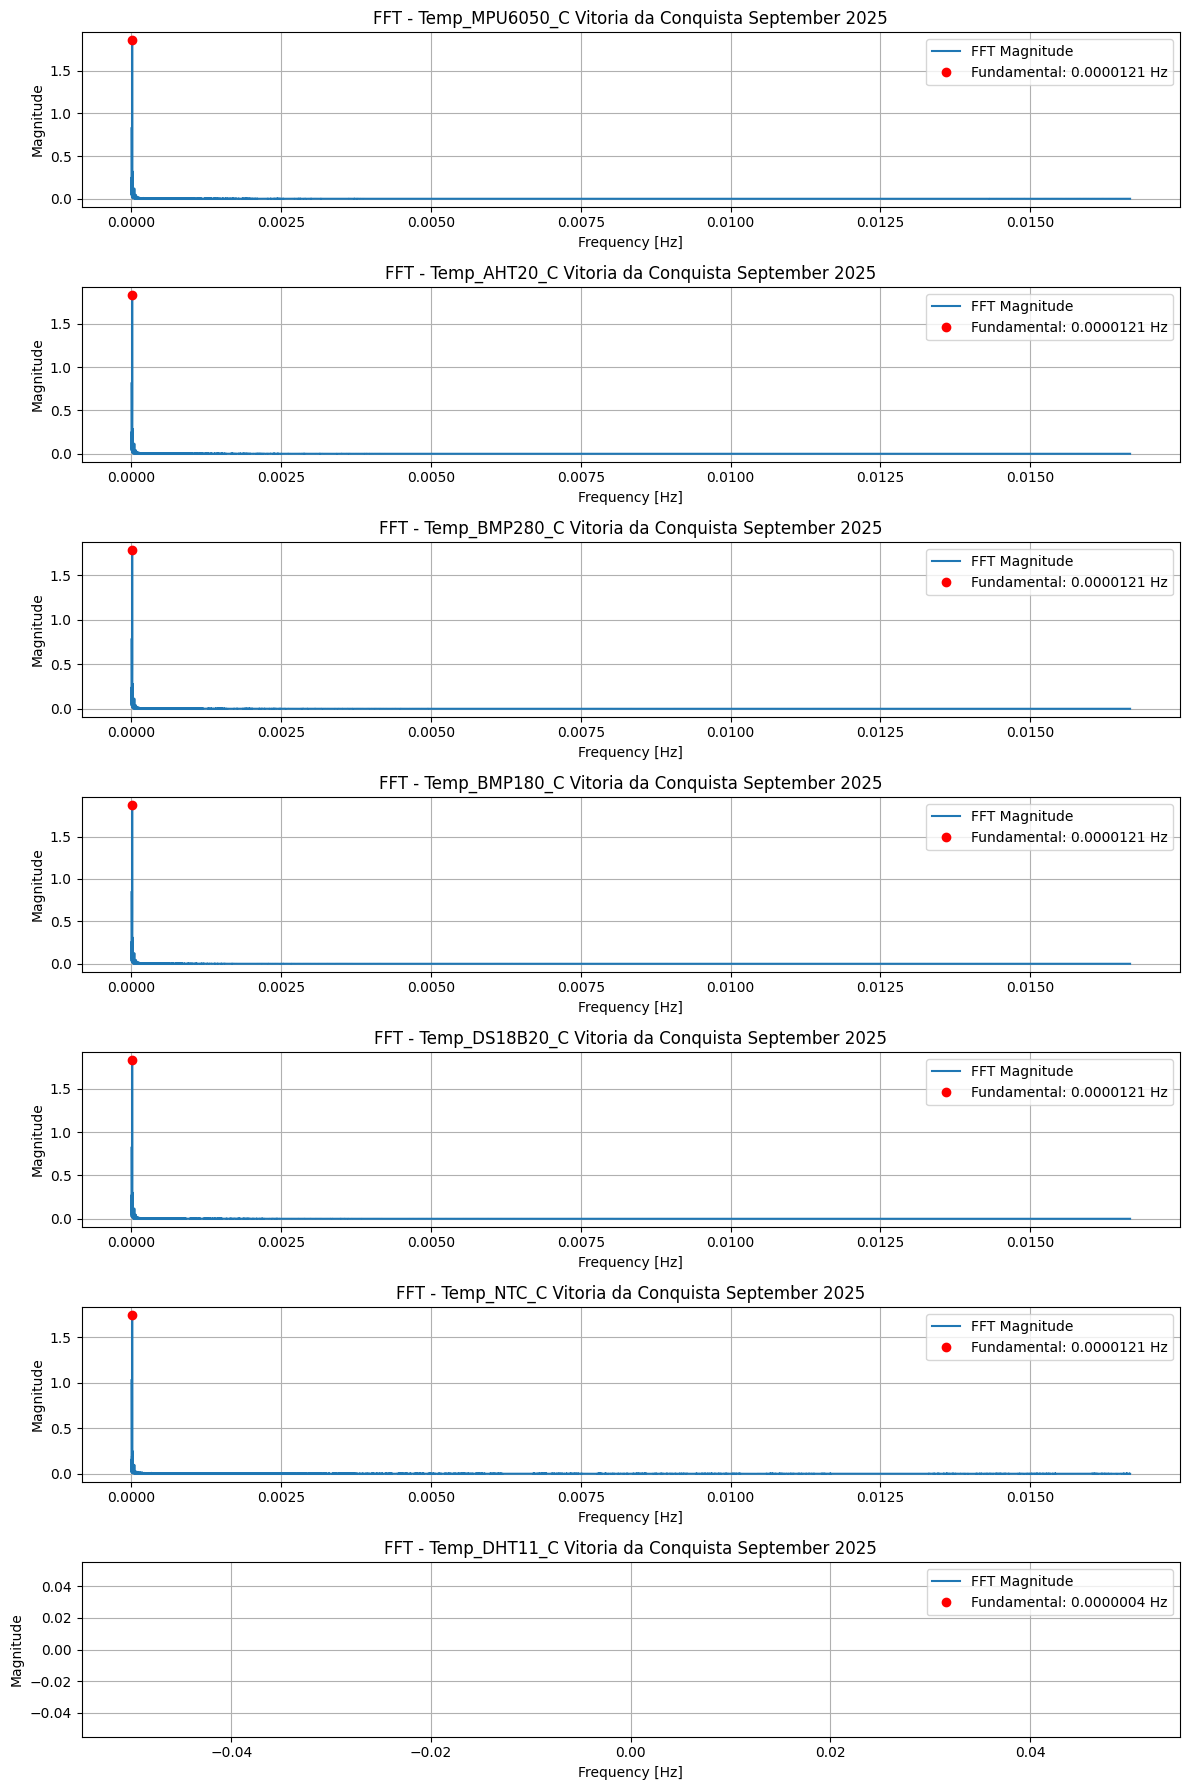

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
                'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C']#all temperature sensors
timestep = 30  # adjust for the sampling interval in seconds
plt.figure(figsize=(12, 18)) #plot figure size

for i, sensor in enumerate(temp_sensors): #for each temperature sensor
    y = df[sensor].values #stores all sensor values
    n = len(y) #gets the size of each sensor
    yf = np.fft.fft(y) #applies the fast fourier transform to the temperature values of each sensor
    xf = np.fft.fftfreq(n, d=timestep) #calculates the frequencies corresponding to each bin (position) of the FFT result.
    idx = np.arange(1, n//2) #only integer numbers
    xf_pos = xf[idx] #only positive values
    yf_pos = np.abs(yf[idx]) / n

    #Fundamental frequency
    fund_idx = np.argmax(yf_pos) #Finds the index of the maximum value of the array
    fund_freq = xf_pos[fund_idx] #finds the frequency corresponding to the maximum index
    fund_mag = yf_pos[fund_idx]# finds the maximum magnitude of this index

    # Plot
    plt.subplot(len(temp_sensors), 1, i+1)
    plt.plot(xf_pos, yf_pos, label='FFT Magnitude')
    plt.plot(fund_freq, fund_mag, 'ro', label=f'Fundamental: {fund_freq:.7f} Hz')
    plt.title(f'FFT - {sensor} Vitoria da Conquista September 2025')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The FFT analysis of temperature sensors revealed a dominant frequency of 0.0000121 Hz (period of aprox 23 hours) across six sensors (MPU6050, AHT20, BMP280, BMP180, DS18B20, and NTC), clearly indicating the circadian cycle of day/night thermal variation. The magnitude of ~1.8 corresponds to a peak-to-peak variation of approximately 7°C, consistent with natural thermal oscillations in Vitória da Conquista during September. The DHT11 sensor showed a discrepant frequency (0.0000004 Hz) and very low magnitude ( aprox 0.04), evidencing its inadequacy for spectral analysis due to its limited 1°C resolution. The results validate the consistency and sensitivity of the other sensors in capturing environmental thermal patterns.